## INTRO

nro id : se não tiver length 16 adicionar 0 na frente

instituição
- hospital : não é de ensino, tem q marcar q não é de academia
- mesma instituição, registros e tempos diferentes  =>  tem q agrupar
similaridade de string -> função cosseno de PLN (ngramas)



1) pegar o nome de todas as instituições do brasil (usar a lista do MEC)


- fazer a tabela de frequência /
eliminar oq tem pouca frequência
- se for secretaria municipal algo assim e aparecer poucas vezes => só rotular como servidor público
- se estiver so EACH (sem ter USP no nome), categorizar como 'outros'
- lista de universidades
    - tabela do ROR
    - tabela do MEC

In [93]:
from google.colab import drive
import os

import pandas as pd
import numpy as np

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/USP/2024_2º/MQA/')

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', None)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## READ_CSV

In [415]:
df = pd.read_csv('atuacoes_2.csv', encoding='UTF-8', nrows=100) #, dtype=str, nrows=1000)

df['ANO-FIM'] = df['ANO-FIM'].fillna(2024)
df['FLAG-DEDICACAO-EXCLUSIVA'] = df['FLAG-DEDICACAO-EXCLUSIVA'].replace('NAO', False).replace('SIM', True)

df = df.astype({
    'NRO-ID-CNPQ': int,
    'CODIGO-INSTITUICAO': str,
    'NOME-INSTITUICAO': str,
    'ANO-INICIO': int,
    'ANO-FIM': int,
    'ENQUADRAMENTO-FUNCIONAL': str,
    'TIPO-DE-VINCULO': str,
    'OUTRAS-INFORMACOES': str,
    'CARGA-HORARIA-SEMANAL': float,
    'FLAG-DEDICACAO-EXCLUSIVA': bool
})

df = df.fillna(' ')
df2 = df.copy()

#df

In [416]:
df2 = df.copy(deep=True)
df2.isna().sum()

,0
NRO-ID-CNPQ,0
CODIGO-INSTITUICAO,0
NOME-INSTITUICAO,0
...,...
OUTRAS-INFORMACOES,0
CARGA-HORARIA-SEMANAL,0
FLAG-DEDICACAO-EXCLUSIVA,0


In [450]:
# LISTA DE UNIVERSIDADES NACIONAIS
# https://dadosabertos.mec.gov.br/indicadores-sobre-ensino-superior/item/181-instituicoes-de-educacao-superior-do-brasil
# https://dadosabertos.mec.gov.br/images/conteudo/Ind-ensino-superior/2022/PDA_Lista_Instituicoes_Ensino_Superior_do_Brasil_EMEC.csv

df_uni = pd.read_csv('sup.csv', encoding='UTF-8')
df_uni_filtered = df_uni[['NOME_DA_IES', 'SIGLA']]
df_uni_filtered = df_uni_filtered.fillna('')
df_uni_filtered = df_uni_filtered.sort_values(['NOME_DA_IES'], ascending=False)
df_uni_filtered

,NOME_DA_IES,SIGLA
862,iCEV - Instituto de Ensino Superior,
2205,VOAS - INSTITUTO DE APRENDIZAGEM SUPERIOR,VOAS
2873,Universidade do Estado de Mato Grosso Carlos A...,UNEMAT
334,Universidade Universus Veritas Guarulhos,Univeritas UNG
4124,Universidade Regional do Cariri,
...,...,...
2416,ACADEMIA JUDICIAL DO TRIBUNAL DE JUSTIÇA DE SA...,AJ
4234,ACADEMIA DE POLÍCIA MILITAR DO ESPÍRITO SANTO,APM/ES
30,ACADEMIA DE POLÍCIA MILITAR DE MINAS GERAIS,APM
3933,ACADEMIA DA FORÇA AÉREA,AFA


## PRE-PROCESSAMENTO

In [451]:
def clean_names(df, column_name):

    # Remove NaN
    #df.dropna(subset=[column_name])

    # Remove '&'
    df[column_name] = df[column_name].replace('&AMP;', ' ', regex=True)

    # Remove any non-alphanumeric characters except whitespace
    df[column_name] = df[column_name].str.replace('[^\w\s]', ' ', regex=True)

    # Normalize string
    df[column_name] = df[column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # Remove stopwords
    stop = ['DO', 'DA', 'DE', 'E']
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # strip whitespace
    df[column_name] = df[column_name].apply(lambda x: x.strip())

    return df

In [452]:
# List of lattes CV

# Clean NOME-INSTITUICAO
df2 = df2.apply(lambda x: x.astype(str).str.upper())
df2 = clean_names(df2, 'NOME-INSTITUICAO')

# Drop rows with frequency less than 50
#df2 = df2[df2.groupby('NOME-INSTITUICAO')['NOME-INSTITUICAO'].transform('count').ge(50)]

# Split df: education & others
df2_edu = df2.loc[df2['ENQUADRAMENTO-FUNCIONAL'].isin(['LIVRE', 'COLABORADOR', 'PROFESSOR_VISITANTE'])].copy(deep=True)
df2_outros = df2.loc[df2['ENQUADRAMENTO-FUNCIONAL'].isin(['SERVIDOR_PUBLICO', 'CELETISTA', 'NAN', 'OUTRO'])].copy(deep=True)

df2_edu

,NRO-ID-CNPQ,CODIGO-INSTITUICAO,NOME-INSTITUICAO,ANO-INICIO,ANO-FIM,ENQUADRAMENTO-FUNCIONAL,TIPO-DE-VINCULO,OUTRAS-INFORMACOES,CARGA-HORARIA-SEMANAL,FLAG-DEDICACAO-EXCLUSIVA
0,3397219421632200,000100000991,HOSPITAL UNIVERSITARIO PROFESSOR ALBERTO ANTUNES,2011,2015,LIVRE,LIVRE,ANALISTA JÚNIOR III,40.0,FALSE
1,3397219421632200,000100000991,HOSPITAL UNIVERSITARIO PROFESSOR ALBERTO ANTUNES,2016,2017,LIVRE,LIVRE,SECRETÁRIO EXECUTIVO,30.0,FALSE
2,3397219421632200,000200000993,SECRETARIA ESTADO EDUCACAO ALAGOAS,2014,2017,LIVRE,LIVRE,PROFESSOR MONITOR DA DISCIPLINA DE GEOGRAFIA,10.0,FALSE
4,3381149537136202,192900000005,UNIVERSIDADE ESTADO PARA,2009,2024,LIVRE,LIVRE,MONITORIA,15.0,TRUE
5,3366254034832265,J58200000003,EDITORA ABRIL,2013,2018,COLABORADOR,LIVRE,TRADUTOR INGLÊS / FRANCES,,FALSE
8,3366254034832265,JGQ800000005,UNYLEYA EDITORA CURSOS S A,2018,2024,LIVRE,LIVRE,PROFESSOR,,FALSE
10,3365167144954943,JAEG00000001,CENTRO UNIVERSITARIO FAMETRO,2011,2012,LIVRE,LIVRE,NAN,,FALSE
11,3362349095856863,IX9B00000009,UNIAO ESCOLAS SUPERIORES RONDONOPOLIS,2007,2024,COLABORADOR,LIVRE,DEPARTAMENTO PESSOAL,44.0,TRUE
12,3362823739227412,063600000000,GOVERNO ESTADO MINAS GERAIS,2019,2024,LIVRE,LIVRE,ESTAGIÁRIO,,FALSE
13,3398572132228377,000100000991,ENDOIMAGEM SERVICOS MEDICOS LTDA,2005,2024,LIVRE,LIVRE,MEDICA ENDOSCOPISTA,,FALSE


In [453]:
print(df2_edu['NOME-INSTITUICAO'].isna().sum())
print(df2_edu['NOME-INSTITUICAO'].value_counts())

0
NOME-INSTITUICAO
UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REIS VELLOSO           7
FACULDADE FRUTAL                                                  3
COLEGIO BRASIL                                                    3
UNIVERSIDADE FEDERAL MATO GROSSO SUL                              3
HOSPITAL UNIVERSITARIO PROFESSOR ALBERTO ANTUNES                  2
PREFEITURA DOM EXPEDITO LOPES                                     2
UNIVERSIDADE FEDERAL PIAUI                                        2
RIOS DIAGNOSTICO                                                  2
TRIBUNAL JUSTICA FEDERAL                                          1
DENTISTA POPULAR                                                  1
FARMACIA PAGUE MENOS                                              1
CENTRO EDUCACIONAL CENECISTA C C LACERDA                          1
CRECHE ESCOLA AMOR MATERNO                                        1
ESTRATEGIA CONCURSOS                                              1
LABORATORIO MUNICIPAL INDAIAL

In [454]:
# List of Universities

df_uni_filtered = df_uni_filtered.apply(lambda x: x.astype(str).str.upper())
df_uni_filtered = clean_names(df_uni_filtered, 'NOME_DA_IES')

# merge NOME and SIGLA column
df_uni_filtered['NOME_E_SIGLA'] = df_uni_filtered['SIGLA'] + ' ' + df_uni_filtered['NOME_DA_IES']
df_uni_filtered

,NOME_DA_IES,SIGLA,NOME_E_SIGLA
862,ICEV INSTITUTO ENSINO SUPERIOR,,ICEV INSTITUTO ENSINO SUPERIOR
2205,VOAS INSTITUTO APRENDIZAGEM SUPERIOR,VOAS,VOAS VOAS INSTITUTO APRENDIZAGEM SUPERIOR
2873,UNIVERSIDADE ESTADO MATO GROSSO CARLOS ALBERTO...,UNEMAT,UNEMAT UNIVERSIDADE ESTADO MATO GROSSO CARLOS ...
334,UNIVERSIDADE UNIVERSUS VERITAS GUARULHOS,UNIVERITAS UNG,UNIVERITAS UNG UNIVERSIDADE UNIVERSUS VERITAS ...
4124,UNIVERSIDADE REGIONAL CARIRI,,UNIVERSIDADE REGIONAL CARIRI
...,...,...,...
2416,ACADEMIA JUDICIAL TRIBUNAL JUSTICA SANTA CATARINA,AJ,AJ ACADEMIA JUDICIAL TRIBUNAL JUSTICA SANTA CA...
4234,ACADEMIA POLICIA MILITAR ESPIRITO SANTO,APM/ES,APM/ES ACADEMIA POLICIA MILITAR ESPIRITO SANTO
30,ACADEMIA POLICIA MILITAR MINAS GERAIS,APM,APM ACADEMIA POLICIA MILITAR MINAS GERAIS
3933,ACADEMIA FORCA AEREA,AFA,AFA ACADEMIA FORCA AEREA


## PLN

### Cosine

In [411]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

threshold = 0.8

# Vetorização TF-IDF
vectorizer = TfidfVectorizer().fit(df_uni_filtered['NOME_DA_IES'])
tfidf_matrix_universidades = vectorizer.transform(df_uni_filtered['NOME_DA_IES'])

# Nova coluna
df2_edu['nome_corrigido'] = ''

for index, row in df2_edu.iterrows():

    nome_instituicao = row['NOME-INSTITUICAO']

    vector_comparacao = vectorizer.transform([nome_instituicao])

    similaridade = cosine_similarity(vector_comparacao, tfidf_matrix_universidades)

    max_value = np.max(similaridade)  # Valor máximo de similaridade
    max_index = np.argmax(similaridade)  # Índice do valor máximo

    nome_corrigido = df_uni_filtered.iloc[max_index]['NOME_DA_IES']

    if (max_value >= threshold):
        df2_edu.at[index, 'nome_corrigido'] = nome_corrigido
    else:
        df2_edu.at[index, 'nome_corrigido'] = nome_instituicao

    #print(max_value, ": ", nome_corrigido, ", ", nome_instituicao)

In [414]:
# oq foi alterado
pd.set_option('display.max_rows', 10)
print(df2_edu[['NOME-INSTITUICAO', 'nome_corrigido']].loc[df2_edu['NOME-INSTITUICAO'] != df2_edu['nome_corrigido']])
pd.set_option('display.max_rows', 6)

                NOME-INSTITUICAO                      nome_corrigido
10  CENTRO UNIVERSITARIO FAMETRO  CENTRO UNIVERSITARIO CEUNI FAMETRO
24                SORVETES LIDER                     FACULDADE LIDER


In [413]:
# SIMILARIDADE POR NOME E SIGLA
# EM QUANTIDADE MAIOR DE AMOSTRA, NAO FUNCIONA MUITO BEM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

threshold = 0.8

# Vetorização TF-IDF
vectorizer = TfidfVectorizer().fit(df_uni_filtered['NOME_E_SIGLA'])
tfidf_matrix_universidades = vectorizer.transform(df_uni_filtered['NOME_E_SIGLA'])

# Nova coluna
df2_edu['nome_corrigido'] = ''

for index, row in df2_edu.iterrows():

    nome_instituicao = row['NOME-INSTITUICAO']

    vector_comparacao = vectorizer.transform([nome_instituicao])

    similaridade = cosine_similarity(vector_comparacao, tfidf_matrix_universidades)

    max_value = np.max(similaridade)  # Valor máximo de similaridade
    max_index = np.argmax(similaridade)  # Índice do valor máximo

    nome_corrigido = df_uni_filtered.iloc[max_index]['NOME_DA_IES']

    if (max_value >= threshold):
        df2_edu.at[index, 'nome_corrigido'] = nome_corrigido
    else:
        df2_edu.at[index, 'nome_corrigido'] = nome_instituicao

    #print(max_value, ": ", nome_corrigido, ", ", nome_instituicao)

### N-gram


In [437]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

threshold = 0.6

vectorizer = TfidfVectorizer(ngram_range=(2, 3)).fit(df_uni_filtered['NOME_DA_IES'])
tfidf_matrix_universidades = vectorizer.transform(df_uni_filtered['NOME_DA_IES'])

# Nova coluna
df2_edu['nome_corrigido_ngram'] = ''

for index, row in df2_edu.iterrows():
    nome_instituicao = row['NOME-INSTITUICAO']

    vector_comparacao = vectorizer.transform([nome_instituicao])

    similaridade = cosine_similarity(vector_comparacao, tfidf_matrix_universidades)

    max_value = np.max(similaridade)  # Valor máximo de similaridade
    max_index = np.argmax(similaridade)  # Índice do valor máximo

    nome_corrigido = df_uni_filtered.iloc[max_index]['NOME_DA_IES']

    if max_value >= threshold:
        df2_edu.at[index, 'nome_corrigido_ngram'] = nome_corrigido
    else:
        df2_edu.at[index, 'nome_corrigido_ngram'] = nome_instituicao

    #print(max_value, ": ", nome_corrigido, ", ", nome_instituicao)


In [438]:
pd.set_option('display.max_rows', 100)
print(df2_edu[['NOME-INSTITUICAO', 'nome_corrigido_ngram']].loc[df2_edu['NOME-INSTITUICAO'] != df2_edu['nome_corrigido_ngram']])

                                     NOME-INSTITUICAO  \
11              UNIAO ESCOLAS SUPERIORES RONDONOPOLIS   
12                        GOVERNO ESTADO MINAS GERAIS   
33        CONSELHO REGIONAL FARMACIA ESTADO SAO PAULO   
38  UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REI...   
39  UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REI...   
40  UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REI...   
41  UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REI...   
42  UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REI...   
43  UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REI...   
44  UNIVERSIDADE FEDERAL PIAUI CAMPUS MINISTRO REI...   
45     LABORATORIO ANALISES CLINICAS SAO VICENTE LTDA   

                nome_corrigido_ngram  
11   UNIAO ESCOLAS SUPERIORES FUNESO  
12  UNIVERSIDADE ESTADO MINAS GERAIS  
33        FACULDADE ESTADO SAO PAULO  
38        UNIVERSIDADE FEDERAL PIAUI  
39        UNIVERSIDADE FEDERAL PIAUI  
40        UNIVERSIDADE FEDERAL PIAUI  
41        UNIVERSIDADE FEDERAL PIAUI  
42 

### Clustering: K-Means

In [ ]:
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer().fit(df_uni_filtered['NOME_E_SIGLA'].values)
tfidf_matrix_1 = vectorizer.transform(df_uni_filtered['NOME_E_SIGLA'].values)

n_clusters = 2754  # quantidade de IES existentes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tfidf_matrix_1)

# Step 5: Get cluster labels and assign each document to a cluster
cluster_labels = kmeans.labels_

for i in range(n_clusters):
    cluster_points = np.where(cluster_labels == i)[0]
    cluster_center = kmeans.cluster_centers_[i]

    # Find document closest to the centroid (most recurring)
    closest_doc_idx = np.argmax(cosine_similarity(tfidf_matrix_1[cluster_points], [cluster_center]))
    most_recurring_idx = cluster_points[closest_doc_idx]
    original_row_index = df2_edu.index[most_recurring_idx]
    most_recurring_document = df2_edu.loc[original_row_index]
    print(most_recurring_document['NOME-INSTITUICAO'])
most_recurring_document

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


UNIVERSIDADE FEDERAL CEARA
UNIVERSIDADE FEDERAL SAO CARLOS
UNIVERSIDADE FEDERAL AMAZONAS
UNIVERSIDADE FEDERAL RIO GRANDE
UNIVERSIDADE ESTADUAL CAMPINAS
FUNDACAO OSWALDO CRUZ
UNIVERSIDADE FEDERAL FLUMINENSE
UNIVERSIDADE PAULISTA
UNIVERSIDADE ESTADUAL PAULISTA JULIO MESQUITA FILHO
UNIVERSIDADE FEDERAL RIO JANEIRO
PONTIFICIA UNIVERSIDADE CATOLICA GOIAS
UNIVERSIDADE FEDERAL CEARA
UNIVERSIDADE ESTACIO SA
UNIVERSIDADE FEDERAL GOIAS
CONSELHO NACIONAL DESENVOLVIMENTO CIENTIFICO TECNOLOGICO
UNIVERSIDADE FEDERAL SANTA CATARINA
UNIVERSIDADE SAO PAULO
UNIVERSIDADE PAULISTA
PONTIFICIA UNIVERSIDADE CATOLICA MINAS GERAIS
UNIVERSIDADE FEDERAL RURAL PERNAMBUCO
UNIVERSIDADE FEDERAL SANTA MARIA
UNIVERSIDADE FEDERAL LAVRAS
UNIVERSIDADE ESTADO PARA
UNIVERSIDADE FEDERAL PARANA
UNIVERSIDADE FEDERAL ESPIRITO SANTO
UNIVERSIDADE ESTADO BAHIA
UNIVERSIDADE FEDERAL GOIAS
UNIVERSIDADE FEDERAL MATO GROSSO SUL
UNIVERSIDADE FEDERAL RIO GRANDE SUL
PONTIFICIA UNIVERSIDADE CATOLICA SAO PAULO
UNIVERSIDADE FEDERAL CAMPINA 

,17997
NRO-ID-CNPQ,3318505161162217
CODIGO-INSTITUICAO,008300000001
NOME-INSTITUICAO,UNIVERSIDADE FEDERAL PARAIBA
ANO-INICIO,2006
ANO-FIM,2024
ENQUADRAMENTO-FUNCIONAL,LIVRE
TIPO-DE-VINCULO,LIVRE
OUTRAS-INFORMACOES,ALUNA MATRICULADA NO CURSO DOUTORADO-PPGE/UFP
CARGA-HORARIA-SEMANAL,
FLAG-DEDICACAO-EXCLUSIVA,FALSE


In [455]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vetorização TF-IDF com n-gramas
vectorizer = TfidfVectorizer().fit(df_uni_filtered['NOME_DA_IES'])
tfidf_matrix_universidades = vectorizer.transform(df_uni_filtered['NOME_DA_IES'])

# Aplicar K-means
num_clusters = 4000
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(tfidf_matrix_universidades)
clusters = kmeans.predict(tfidf_matrix_universidades)

# Adicionar os rótulos de cluster ao DataFrame
df_uni_filtered['cluster'] = clusters

# Crie um dicionário para armazenar o nome mais representativo de cada cluster
representative_names = {}
for cluster in range(num_clusters):
    cluster_names = df_uni_filtered[df_uni_filtered['cluster'] == cluster]['NOME_DA_IES']
    # Escolha o nome mais frequente no cluster como representante
    representative_names[cluster] = cluster_names.mode()[0]

# Nova coluna
df2_edu['nome_corrigido_kmeans'] = ''

for index, row in df2_edu.iterrows():
    nome_instituicao = row['NOME-INSTITUICAO']

    vector_comparacao = vectorizer.transform([nome_instituicao])

    # Prever o cluster para o nome da instituição
    cluster_prediction = kmeans.predict(vector_comparacao)[0]

    # Obter o nome mais representativo do cluster
    nome_corrigido = representative_names.get(cluster_prediction, nome_instituicao)

    df2_edu.at[index, 'nome_corrigido_kmeans'] = nome_corrigido

    # print(f'{nome_instituicao} corrigido para {nome_corrigido}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [457]:
pd.set_option('display.max_rows', 100)
print(df2_edu[['NOME-INSTITUICAO', 'nome_corrigido_kmeans']].loc[df2_edu['NOME-INSTITUICAO'] != df2_edu['nome_corrigido_kmeans']])

                                     NOME-INSTITUICAO  \
0    HOSPITAL UNIVERSITARIO PROFESSOR ALBERTO ANTUNES   
1    HOSPITAL UNIVERSITARIO PROFESSOR ALBERTO ANTUNES   
2                  SECRETARIA ESTADO EDUCACAO ALAGOAS   
5                                       EDITORA ABRIL   
8                          UNYLEYA EDITORA CURSOS S A   
11              UNIAO ESCOLAS SUPERIORES RONDONOPOLIS   
12                        GOVERNO ESTADO MINAS GERAIS   
13                   ENDOIMAGEM SERVICOS MEDICOS LTDA   
14                                      AMIU BOTAFOGO   
18         MARTINS COMERCIO SERVICOS DISTRIBUICAO S A   
19                     SUPERMERCADO BRASIL NORTE LTDA   
20                         COMERCIAL REAL CARNES LTDA   
21                   LANCHONETE SORVETERIA PISTACHIOS   
22                                        MEISTER S A   
23      DEPARTAMENTO MUNICIPAL AGUA ESGOTO UBERLANDIA   
24                                     SORVETES LIDER   
25                CONTA FACIL P

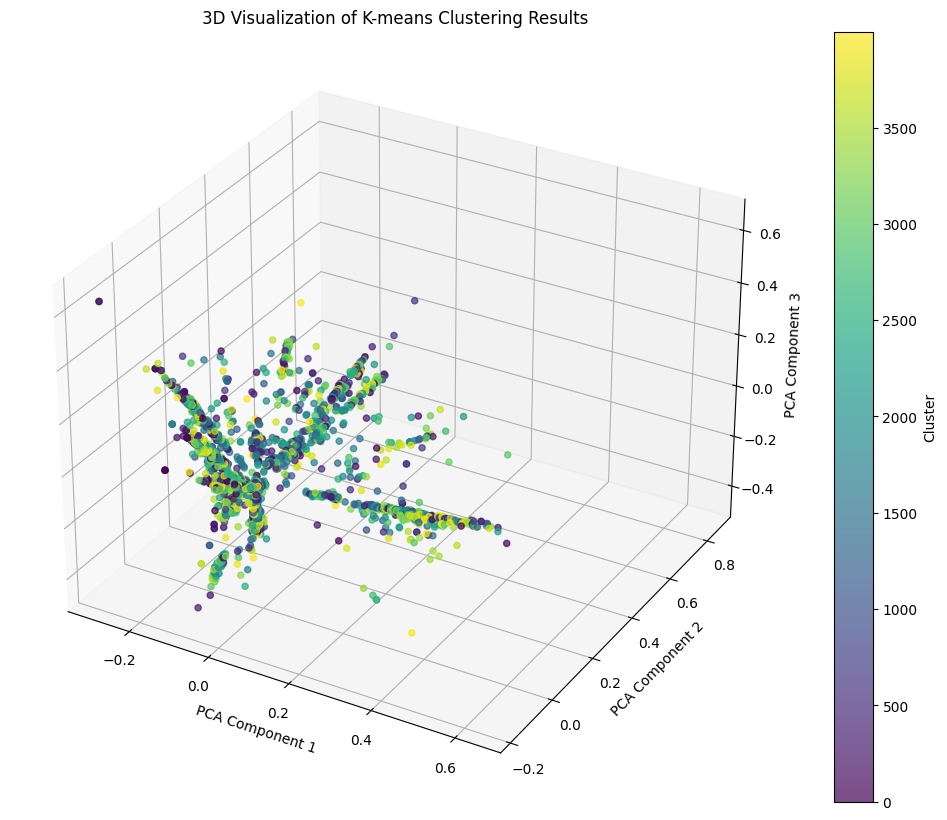

In [456]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Reduzir dimensionalidade com PCA para 3 componentes
pca = PCA(n_components=3)  # Reduzir para 3 dimensões
reduced_features = pca.fit_transform(tfidf_matrix_universidades.toarray())

# Adicionar as dimensões reduzidas e os rótulos de cluster ao DataFrame
df_uni_filtered['pca1'] = reduced_features[:, 0]
df_uni_filtered['pca2'] = reduced_features[:, 1]
df_uni_filtered['pca3'] = reduced_features[:, 2]
df_uni_filtered['cluster'] = clusters

# Plotar os resultados em 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_uni_filtered['pca1'], df_uni_filtered['pca2'], df_uni_filtered['pca3'],
                     c=df_uni_filtered['cluster'], cmap='viridis', alpha=0.7)

# Adicionar barra de cores
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Configurar rótulos dos eixos
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Adicionar título
plt.title('3D Visualization of K-means Clustering Results')

plt.show()


In [444]:
reduced_features

array([[-0.10272592, -0.07764126,  0.24323273],
       [-0.04120446, -0.04670481, -0.01800805],
       [-0.00612176, -0.01246881, -0.18449895],
       ...,
       [-0.05459028, -0.04725616,  0.00973125],
       [-0.08743185, -0.07619147,  0.09991366],
       [-0.01095192,  0.1745261 , -0.01342837]])

### Word Embedding
- muito lentooo
- 50k linhas : 3min

In [ ]:
!python -m spacy download pt_core_news_sm
import spacy

# AJUSTAR O CODIGO PQ NAO TROCA A COLUNA NEM NADA

nlp = spacy.load("pt_core_news_sm")  # Carrega um modelo pré-treinado
df2['spacy_similarity'] = df2.apply(
    lambda row: nlp(row['NOME-INSTITUICAO']).similarity(nlp(df_uni_filtered['NOME_DA_IES'][row['indice_mais_similar']])),
    axis=1
)

df2

### Word2Vect

## MERGE SAME UNI

In [ ]:
# merge ANO-INICIO and ANO-FIM with same CODIGO-INSTITUICAO and NRO-ID-CNPQ

df_merged = df.groupby(['NRO-ID-CNPQ', 'CODIGO-INSTITUICAO']).agg(
    earliest_date1=('ANO-INICIO', 'min'),
    latest_date2=('ANO-FIM', 'max')
).reset_index()


# df.loc[df['NRO-ID-CNPQ'] == 3300778291054405]

In [ ]:
# merge column NOME-INSTITUICAO with df_merged

df_drop_duplicates = df.drop_duplicates(subset=['NRO-ID-CNPQ', 'CODIGO-INSTITUICAO'])
df_inst_merged = pd.merge(df_merged, df_drop_duplicates, on=['CODIGO-INSTITUICAO', 'NRO-ID-CNPQ'], how='left')
df_inst_merged['NOME-INSTITUICAO'] = df_inst_merged['NOME-INSTITUICAO'].str.upper()

df_inst_merged = df_inst_merged[['NRO-ID-CNPQ', 'CODIGO-INSTITUICAO', 'earliest_date1', 'latest_date2', 'NOME-INSTITUICAO']]
df_inst_merged

## Save

In [ ]:
df_inst_merged.to_csv("atuacoes_2_filtrado.csv", encoding='utf8')